In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
import pickle
from collections import Counter
# Initialize all recommenders
import sys, os
sys.path.append(os.path.abspath(".."))  # add parent directory

from src.content_base_recommender import ContentBasedRecommender
from src.text_based_recommender import TextBasedRecommender
from src.hybrid_recommender import HybridRecommender
# recommenders import ContentBasedRecommender, TextBasedRecommender,HybridRecommender
import warnings
warnings.filterwarnings('ignore')
model_path ="../trained_model"
# Load saved models and data
with open(f'{model_path}/content_recommender.pkl', 'rb') as f:
    content_recommender = pickle.load(f)

with open(f'{model_path}/text_recommender.pkl', 'rb') as f:
    text_recommender = pickle.load(f)

with open(f'{model_path}/hybrid_recommender.pkl', 'rb') as f:
    hybrid_recommender = pickle.load(f)



In [ ]:
df_clean = pd.read_csv('../processed_data/processed_restaurant_data.csv')

print(" MODELS AND DATA LOADED")
print(f"Total restaurants: {len(df_clean)}")

=== MODELS AND DATA LOADED ===
Total restaurants: 31030


In [5]:
class RecommendationEvaluator:
    def __init__(self, restaurant_data, recommenders):
        self.restaurant_data = restaurant_data
        self.recommenders = recommenders
        
    def calculate_diversity(self, recommendations, diversity_type='cuisine'):
        """Calculate diversity of recommendations"""
        if diversity_type == 'cuisine':
            cuisines = []
            for cuisine_list in recommendations['cuisines']:
                if pd.notna(cuisine_list):
                    cuisines.extend([c.strip() for c in str(cuisine_list).split(',')])
            unique_cuisines = len(set(cuisines))
            total_cuisines = len(cuisines)
            return unique_cuisines / total_cuisines if total_cuisines > 0 else 0
        
        elif diversity_type == 'location':
            unique_locations = recommendations['location'].nunique()
            total_locations = len(recommendations)
            return unique_locations / total_locations if total_locations > 0 else 0
        
        elif diversity_type == 'price':
            price_ranges = []
            for cost in recommendations['cost_for_two']:
                if pd.notna(cost):
                    if cost <= 300:
                        price_ranges.append('Budget')
                    elif cost <= 600:
                        price_ranges.append('Mid-range')
                    elif cost <= 1200:
                        price_ranges.append('Expensive')
                    else:
                        price_ranges.append('Premium')
            unique_ranges = len(set(price_ranges))
            total_ranges = len(price_ranges)
            return unique_ranges / total_ranges if total_ranges > 0 else 0
        
        return 0
    
    def calculate_coverage(self, test_restaurants, n_recommendations=10):
        """Calculate recommendation coverage"""
        coverage_results = {}
        
        for recommender_name, recommender in self.recommenders.items():
            successful_recommendations = 0
            total_recommendations_made = set()
            
            for restaurant in test_restaurants:
                try:
                    if recommender_name == 'hybrid':
                        recs = recommender.get_hybrid_recommendations(restaurant, n_recommendations)
                    else:
                        recs = recommender.get_recommendations(restaurant, n_recommendations)
                    
                    if not isinstance(recs, str) and len(recs) > 0:
                        successful_recommendations += 1
                        total_recommendations_made.update(recs['name'].tolist())
                except:
                    continue
            
            coverage = len(total_recommendations_made) / len(self.restaurant_data)
            success_rate = successful_recommendations / len(test_restaurants)
            
            coverage_results[recommender_name] = {
                'coverage': coverage,
                'success_rate': success_rate,
                'unique_recommendations': len(total_recommendations_made)
            }
        
        return coverage_results
    
    def calculate_similarity_distribution(self, test_restaurants, n_recommendations=10):
        """Analyze similarity score distributions"""
        similarity_results = {}
        
        for recommender_name, recommender in self.recommenders.items():
            all_scores = []
            
            for restaurant in test_restaurants[:20]:  # Limit for performance
                try:
                    if recommender_name == 'hybrid':
                        recs = recommender.get_hybrid_recommendations(restaurant, n_recommendations)
                        score_col = 'hybrid_score'
                    else:
                        recs = recommender.get_recommendations(restaurant, n_recommendations)
                        score_col = 'similarity_score'
                    
                    if not isinstance(recs, str) and score_col in recs.columns:
                        all_scores.extend(recs[score_col].tolist())
                except:
                    continue
            
            if all_scores:
                similarity_results[recommender_name] = {
                    'mean_similarity': np.mean(all_scores),
                    'std_similarity': np.std(all_scores),
                    'min_similarity': np.min(all_scores),
                    'max_similarity': np.max(all_scores),
                    'scores': all_scores
                }
        
        return similarity_results

# Initialize evaluator
recommenders = {
    'content': content_recommender,
    'text': text_recommender,
    'hybrid': hybrid_recommender
}

evaluator = RecommendationEvaluator(df_clean, recommenders)

=== SELECTING TEST RESTAURANTS ===
Selected 30 test restaurants

=== RUNNING COMPREHENSIVE EVALUATION ===
1. Calculating coverage...
Coverage Results:
  CONTENT:
    Coverage: 0.003
    Success Rate: 1.000
    Unique Recommendations: 104
  TEXT:
    Coverage: 0.003
    Success Rate: 1.000
    Unique Recommendations: 98
  HYBRID:
    Coverage: 0.007
    Success Rate: 1.000
    Unique Recommendations: 231

2. Calculating similarity distributions...


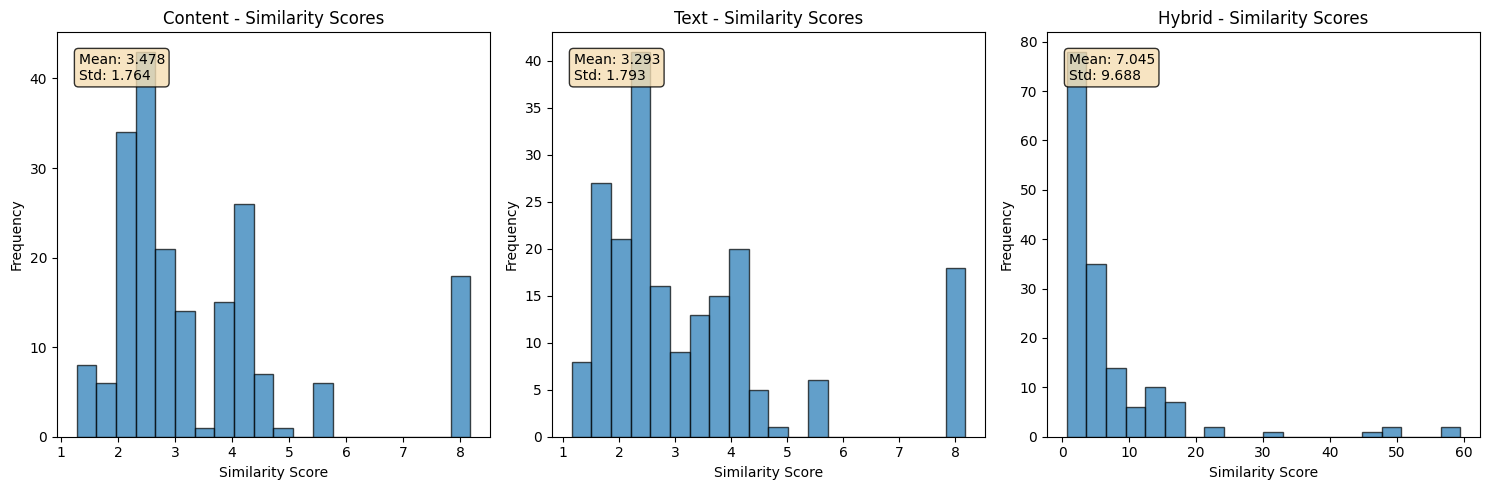

In [ ]:
# Select test restaurants (diverse sample)
print("SELECTING TEST RESTAURANTS ")

# Get restaurants from different categories
test_restaurants = []

# High-rated restaurants
high_rated = df_clean[df_clean['rating'] >= 4.0]['name'].sample(10, random_state=42).tolist()
test_restaurants.extend(high_rated)

# Different locations
popular_locations = df_clean['location'].value_counts().head(5).index
for location in popular_locations:
    location_restaurants = df_clean[df_clean['location'] == location]['name'].sample(2, random_state=42).tolist()
    test_restaurants.extend(location_restaurants)

# Different cuisines
popular_cuisines = ['North Indian', 'Chinese', 'South Indian', 'Italian', 'Continental']
for cuisine in popular_cuisines:
    cuisine_restaurants = df_clean[df_clean['cuisines'].str.contains(cuisine, na=False)]['name'].sample(2, random_state=42).tolist()
    test_restaurants.extend(cuisine_restaurants)

# Remove duplicates
test_restaurants = list(set(test_restaurants))
print(f"Selected {len(test_restaurants)} test restaurants")

# Run comprehensive evaluation
print("\n=== RUNNING COMPREHENSIVE EVALUATION ===")

# 1. Coverage Analysis
print("1. Calculating coverage...")
coverage_results = evaluator.calculate_coverage(test_restaurants)
print("Coverage Results:")
for method, results in coverage_results.items():
    print(f"  {method.upper()}:")
    print(f"    Coverage: {results['coverage']:.3f}")
    print(f"    Success Rate: {results['success_rate']:.3f}")
    print(f"    Unique Recommendations: {results['unique_recommendations']}")

# 2. Similarity Distribution Analysis
print("\n2. Calculating similarity distributions...")
similarity_results = evaluator.calculate_similarity_distribution(test_restaurants)

# Visualize similarity distributions
plt.figure(figsize=(15, 5))

for i, (method, results) in enumerate(similarity_results.items(), 1):
    plt.subplot(1, 3, i)
    plt.hist(results['scores'], bins=20, alpha=0.7, edgecolor='black')
    plt.title(f'{method.title()} - Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.text(0.05, 0.95, f"Mean: {results['mean_similarity']:.3f}\nStd: {results['std_similarity']:.3f}", 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

DIVERSITY ANALYSIS

Analyzing diversity for CONTENT recommender:

Analyzing diversity for TEXT recommender:

Analyzing diversity for HYBRID recommender:

Diversity Summary:
         avg_cuisine_diversity  avg_location_diversity  avg_price_diversity  \
content                  0.194                   0.110                0.180   
text                     0.170                   0.110                0.180   
hybrid                   0.394                   0.411                0.351   

         std_cuisine_diversity  std_location_diversity  std_price_diversity  
content                  0.147                   0.030                0.060  
text                     0.091                   0.030                0.060  
hybrid                   0.131                   0.186                0.145  


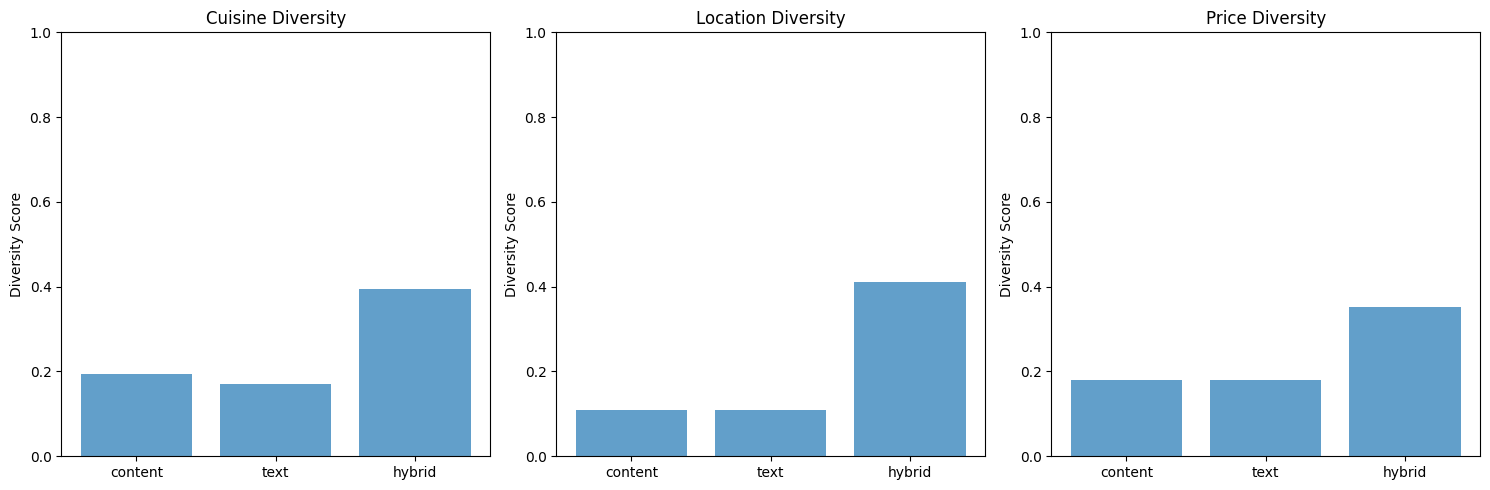

In [7]:
# Analyze diversity for each recommender
print("DIVERSITY ANALYSIS")

diversity_results = {}

for method_name, recommender in recommenders.items():
    print(f"\nAnalyzing diversity for {method_name.upper()} recommender:")
    
    method_diversity = {
        'cuisine_diversity': [],
        'location_diversity': [],
        'price_diversity': []
    }
    
    # Test on sample restaurants
    sample_restaurants = test_restaurants[:10]
    
    for restaurant in sample_restaurants:
        try:
            if method_name == 'hybrid':
                recs = recommender.get_hybrid_recommendations(restaurant, 10)
            else:
                recs = recommender.get_recommendations(restaurant, 10)
            
            if not isinstance(recs, str) and len(recs) > 0:
                # Calculate different types of diversity
                cuisine_div = evaluator.calculate_diversity(recs, 'cuisine')
                location_div = evaluator.calculate_diversity(recs, 'location')
                price_div = evaluator.calculate_diversity(recs, 'price')
                
                method_diversity['cuisine_diversity'].append(cuisine_div)
                method_diversity['location_diversity'].append(location_div)
                method_diversity['price_diversity'].append(price_div)
        except:
            continue
    
    # Calculate average diversity
    diversity_results[method_name] = {
        'avg_cuisine_diversity': np.mean(method_diversity['cuisine_diversity']) if method_diversity['cuisine_diversity'] else 0,
        'avg_location_diversity': np.mean(method_diversity['location_diversity']) if method_diversity['location_diversity'] else 0,
        'avg_price_diversity': np.mean(method_diversity['price_diversity']) if method_diversity['price_diversity'] else 0,
        'std_cuisine_diversity': np.std(method_diversity['cuisine_diversity']) if method_diversity['cuisine_diversity'] else 0,
        'std_location_diversity': np.std(method_diversity['location_diversity']) if method_diversity['location_diversity'] else 0,
        'std_price_diversity': np.std(method_diversity['price_diversity']) if method_diversity['price_diversity'] else 0
    }

# Display diversity results
diversity_df = pd.DataFrame(diversity_results).T
print("\nDiversity Summary:")
print(diversity_df.round(3))

# Visualize diversity comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

diversity_types = ['avg_cuisine_diversity', 'avg_location_diversity', 'avg_price_diversity']
titles = ['Cuisine Diversity', 'Location Diversity', 'Price Diversity']

for i, (div_type, title) in enumerate(zip(diversity_types, titles)):
    values = [diversity_results[method][div_type] for method in recommenders.keys()]
    axes[i].bar(recommenders.keys(), values, alpha=0.7)
    axes[i].set_title(title)
    axes[i].set_ylabel('Diversity Score')
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [8]:
# Manual inspection of recommendation quality
print("QUALITATIVE EVALUATION")

def qualitative_analysis(restaurant_name, n_recommendations=5):
    """Perform qualitative analysis on recommendations"""
    
    print(f"\nQUALITATIVE ANALYSIS FOR: {restaurant_name}")
    
    
    # Get original restaurant details
    original_restaurant = df_clean[df_clean['name'] == restaurant_name].iloc[0]
    print(f"Original Restaurant:")
    print(f"  Cuisine: {original_restaurant['cuisines']}")
    print(f"  Location: {original_restaurant['location']}")
    print(f"  Rating: {original_restaurant['rating']}")
    print(f"  Cost: ₹{original_restaurant['cost_for_two']}")
    print(f"  Type: {original_restaurant['rest_type']}")
    
    # Get recommendations from each method
    methods_to_test = ['content', 'text', 'hybrid']
    
    for method in methods_to_test:
        print(f"\n--- {method.upper()} RECOMMENDATIONS ---")
        
        try:
            if method == 'hybrid':
                recs = hybrid_recommender.get_hybrid_recommendations(restaurant_name, n_recommendations)
                score_col = 'hybrid_score'
            else:
                recommender = content_recommender if method == 'content' else text_recommender
                recs = recommender.get_recommendations(restaurant_name, n_recommendations)
                score_col = 'similarity_score'
            
            if isinstance(recs, str):
                print(f"Error: {recs}")
                continue
            
            for idx, row in recs.iterrows():
                print(f"{idx+1}. {row['name']}")
                print(f"   Cuisine: {row['cuisines']}")
                print(f"   Location: {row['location']}")
                print(f"   Rating: {row['rating']} | Cost: ₹{row['cost_for_two']}")
                print(f"   Score: {row[score_col]:.3f}")
                print()
                
        except Exception as e:
            print(f"Error getting {method} recommendations: {e}")

# Perform qualitative analysis on sample restaurants
sample_restaurants_for_analysis = [
    df_clean[df_clean['cuisines'].str.contains('North Indian', na=False)]['name'].iloc[0],
    df_clean[df_clean['cuisines'].str.contains('Chinese', na=False)]['name'].iloc[0],
    df_clean[df_clean['location'] == 'BTM']['name'].iloc[0] if 'BTM' in df_clean['location'].values else df_clean['name'].iloc[0]
]

for restaurant in sample_restaurants_for_analysis[:2]:  # Limit for space
    qualitative_analysis(restaurant)

QUALITATIVE EVALUATION

QUALITATIVE ANALYSIS FOR: Angel Restaurant
Original Restaurant:
  Cuisine: Kerala, South Indian, North Indian
  Location: Bannerghatta Road
  Rating: 2.8
  Cost: ₹450.0
  Type: Quick Bites

--- CONTENT RECOMMENDATIONS ---
13790. Angel Restaurant
   Cuisine: Kerala, South Indian, North Indian
   Location: Bannerghatta Road
   Rating: 2.8 | Cost: ₹450.0
   Score: 2.080

20277. Angel Restaurant
   Cuisine: Kerala, South Indian, North Indian
   Location: Bannerghatta Road
   Rating: 2.8 | Cost: ₹450.0
   Score: 2.080

2. Angel Restaurant
   Cuisine: Kerala, South Indian, North Indian
   Location: Bannerghatta Road
   Rating: 2.8 | Cost: ₹450.0
   Score: 2.080

18698. Angel Restaurant
   Cuisine: Kerala, South Indian, North Indian
   Location: Bannerghatta Road
   Rating: 2.8 | Cost: ₹450.0
   Score: 2.080

18431. A2B - Adyar Ananda Bhavan
   Cuisine: South Indian, North Indian, Chinese, Street Food
   Location: Bannerghatta Road
   Rating: 2.7 | Cost: ₹400.0
   Scor

COMPREHENSIVE PERFORMANCE SUMMARY

PERFORMANCE COMPARISON TABLE:
         coverage  success_rate  unique_recommendations  avg_similarity  \
content     0.003           1.0                   104.0           3.478   
text        0.003           1.0                    98.0           3.293   
hybrid      0.007           1.0                   231.0           7.045   

         similarity_std  cuisine_diversity  location_diversity  \
content           1.764              0.194               0.110   
text              1.793              0.170               0.110   
hybrid            9.688              0.394               0.411   

         price_diversity  
content            0.180  
text               0.180  
hybrid             0.351  


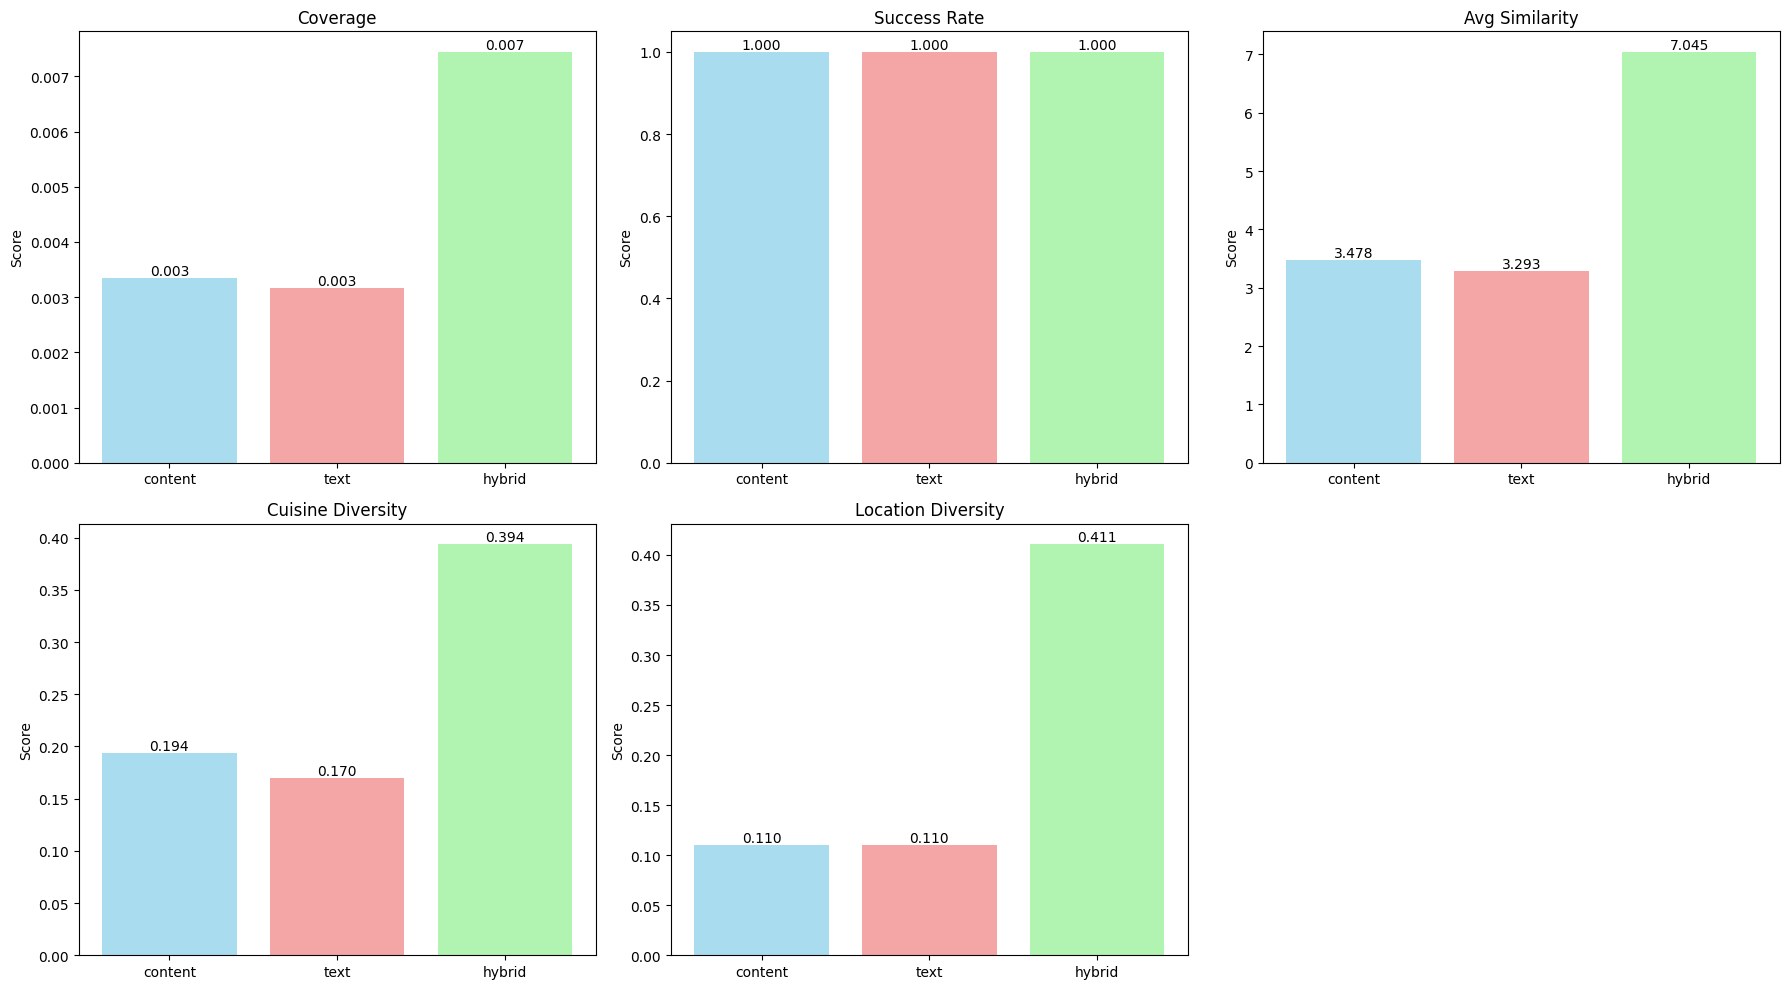

In [9]:
# Create comprehensive performance summary
print("COMPREHENSIVE PERFORMANCE SUMMARY")

performance_metrics = {}

for method_name in recommenders.keys():
    metrics = {}
    
    # From coverage results
    if method_name in coverage_results:
        metrics.update(coverage_results[method_name])
    
    # From similarity results
    if method_name in similarity_results:
        metrics.update({
            'avg_similarity': similarity_results[method_name]['mean_similarity'],
            'similarity_std': similarity_results[method_name]['std_similarity']
        })
    
    # From diversity results
    if method_name in diversity_results:
        metrics.update({
            'cuisine_diversity': diversity_results[method_name]['avg_cuisine_diversity'],
            'location_diversity': diversity_results[method_name]['avg_location_diversity'],
            'price_diversity': diversity_results[method_name]['avg_price_diversity']
        })
    
    performance_metrics[method_name] = metrics

# Create performance comparison table
performance_df = pd.DataFrame(performance_metrics).T
print("\nPERFORMANCE COMPARISON TABLE:")
print(performance_df.round(3))

# Visualize overall performance
metrics_to_plot = ['coverage', 'success_rate', 'avg_similarity', 'cuisine_diversity', 'location_diversity']
available_metrics = [m for m in metrics_to_plot if m in performance_df.columns]

if available_metrics:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(available_metrics):
        if i < len(axes):
            values = performance_df[metric].values
            methods = performance_df.index.tolist()
            
            bars = axes[i].bar(methods, values, alpha=0.7, 
                             color=['skyblue', 'lightcoral', 'lightgreen'][:len(methods)])
            axes[i].set_title(f'{metric.replace("_", " ").title()}')
            axes[i].set_ylabel('Score')
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2., height,
                           f'{value:.3f}', ha='center', va='bottom')
    
    # Hide unused subplots
    for i in range(len(available_metrics), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

RECOMMENDATION QUALITY ANALYSIS

Analyzing patterns for CONTENT recommender:
  Top 5 recommended cuisines: [('North Indian', 38), ('Continental', 36), ('South Indian', 21), ('Finger Food', 20), ('Pizza', 19)]
  Top 5 recommended locations: [('Whitefield', 10), ('HSR', 10), ('Sarjapur Road', 10), ('Brigade Road', 10), ('Koramangala 5th Block', 10)]
  Average rating of recommendations: 3.95
  Average cost of recommendations: ₹818

Analyzing patterns for TEXT recommender:
  Top 5 recommended cuisines: [('North Indian', 41), ('Continental', 31), ('South Indian', 22), ('Finger Food', 20), ('Pizza', 20)]
  Top 5 recommended locations: [('Whitefield', 10), ('HSR', 10), ('Sarjapur Road', 10), ('Brigade Road', 10), ('Koramangala 5th Block', 10)]
  Average rating of recommendations: 3.95
  Average cost of recommendations: ₹822

Analyzing patterns for HYBRID recommender:
  Top 5 recommended cuisines: [('North Indian', 37), ('Continental', 24), ('South Indian', 22), ('Chinese', 20), ('Pizza', 14)]

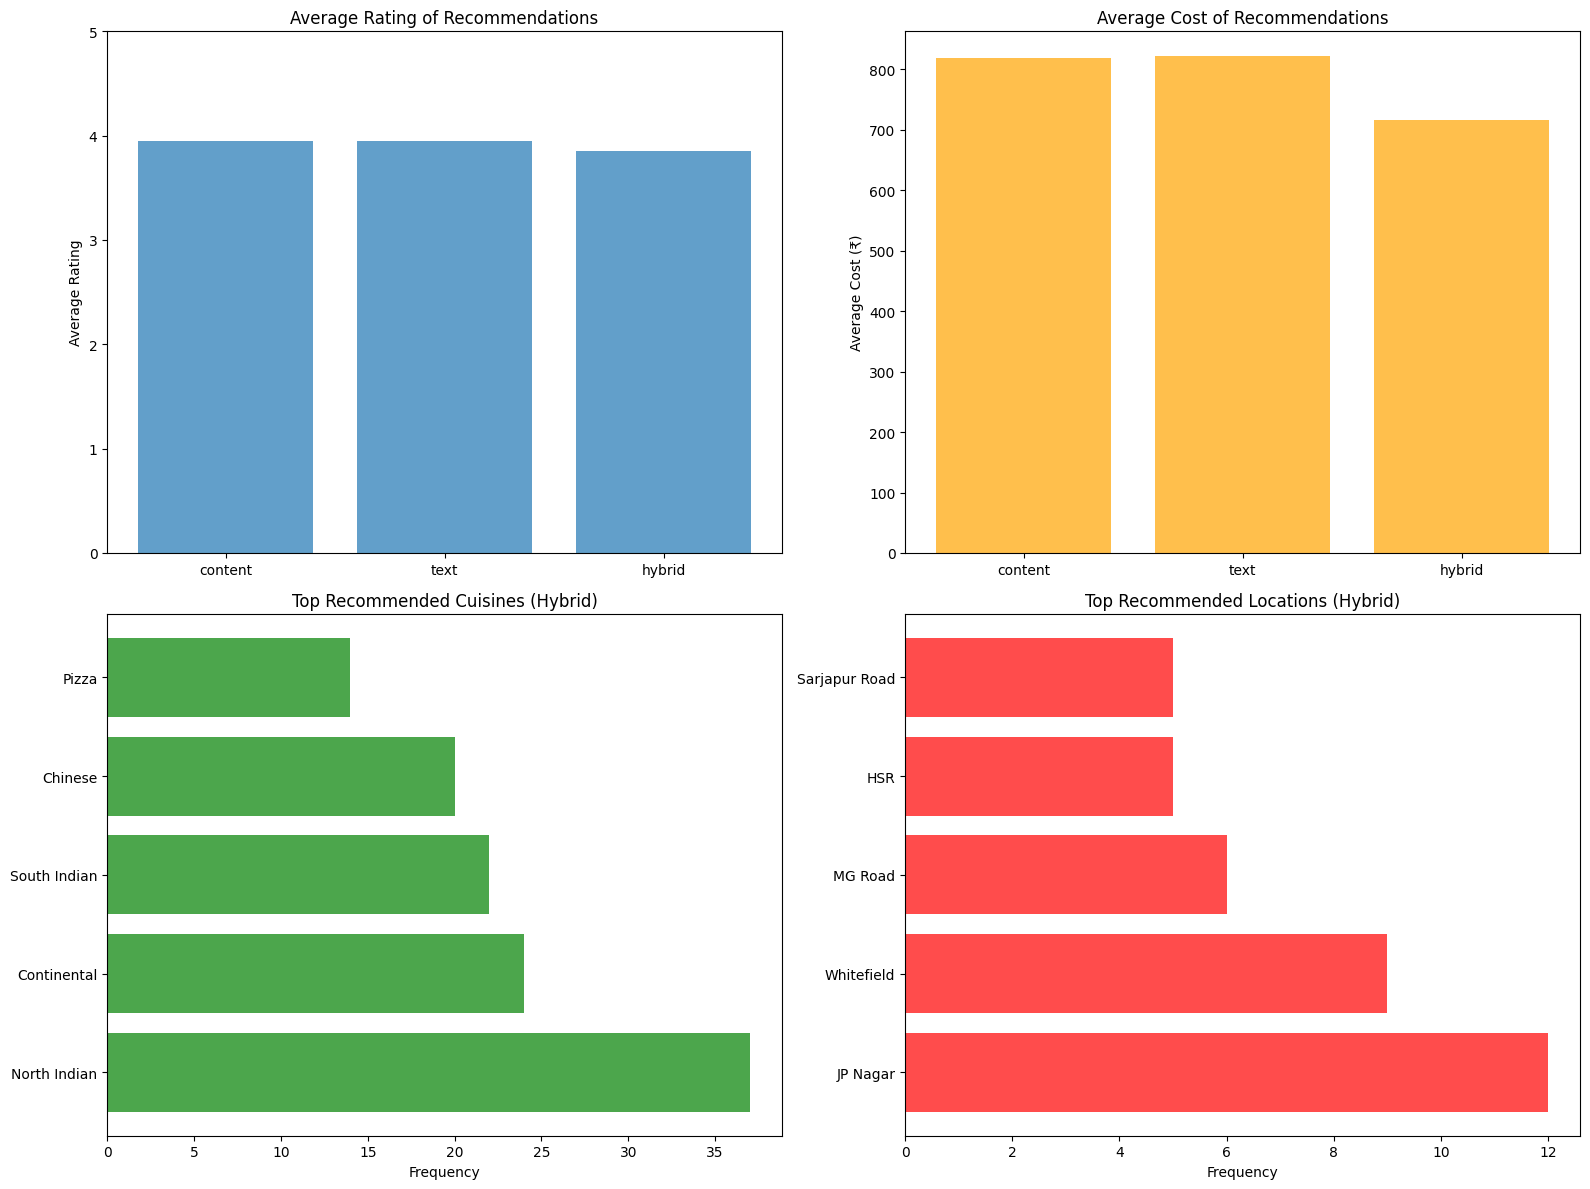

In [10]:
# Analyze recommendation quality patterns
print("RECOMMENDATION QUALITY ANALYSIS")

def analyze_recommendation_patterns():
    """Analyze patterns in recommendations"""
    
    pattern_analysis = {}
    
    for method_name, recommender in recommenders.items():
        print(f"\nAnalyzing patterns for {method_name.upper()} recommender:")
        
        # Track recommendation patterns
        cuisine_recommendations = Counter()
        location_recommendations = Counter()
        rating_recommendations = []
        cost_recommendations = []
        
        sample_size = min(20, len(test_restaurants))
        
        for restaurant in test_restaurants[:sample_size]:
            try:
                if method_name == 'hybrid':
                    recs = recommender.get_hybrid_recommendations(restaurant, 5)
                else:
                    recs = recommender.get_recommendations(restaurant, 5)
                
                if not isinstance(recs, str) and len(recs) > 0:
                    # Count cuisines
                    for cuisines in recs['cuisines'].dropna():
                        cuisine_list = [c.strip() for c in str(cuisines).split(',')]
                        cuisine_recommendations.update(cuisine_list)
                    
                    # Count locations
                    location_recommendations.update(recs['location'].dropna().tolist())
                    
                    # Collect ratings and costs
                    rating_recommendations.extend(recs['rating'].dropna().tolist())
                    cost_recommendations.extend(recs['cost_for_two'].dropna().tolist())
                    
            except Exception as e:
                continue
        
        # Analyze patterns
        top_cuisines = cuisine_recommendations.most_common(5)
        top_locations = location_recommendations.most_common(5)
        avg_rating = np.mean(rating_recommendations) if rating_recommendations else 0
        avg_cost = np.mean(cost_recommendations) if cost_recommendations else 0
        
        pattern_analysis[method_name] = {
            'top_cuisines': top_cuisines,
            'top_locations': top_locations,
            'avg_recommended_rating': avg_rating,
            'avg_recommended_cost': avg_cost,
            'total_recommendations_analyzed': len(rating_recommendations)
        }
        
        print(f"  Top 5 recommended cuisines: {top_cuisines}")
        print(f"  Top 5 recommended locations: {top_locations}")
        print(f"  Average rating of recommendations: {avg_rating:.2f}")
        print(f"  Average cost of recommendations: ₹{avg_cost:.0f}")
    
    return pattern_analysis

pattern_results = analyze_recommendation_patterns()

# Visualize recommendation patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Average rating of recommendations
methods = list(pattern_results.keys())
avg_ratings = [pattern_results[method]['avg_recommended_rating'] for method in methods]

axes[0,0].bar(methods, avg_ratings, alpha=0.7)
axes[0,0].set_title('Average Rating of Recommendations')
axes[0,0].set_ylabel('Average Rating')
axes[0,0].set_ylim(0, 5)

# Plot 2: Average cost of recommendations
avg_costs = [pattern_results[method]['avg_recommended_cost'] for method in methods]

axes[0,1].bar(methods, avg_costs, alpha=0.7, color='orange')
axes[0,1].set_title('Average Cost of Recommendations')
axes[0,1].set_ylabel('Average Cost (₹)')

# Plot 3: Top cuisines distribution (for hybrid method)
if 'hybrid' in pattern_results:
    top_cuisines_hybrid = pattern_results['hybrid']['top_cuisines'][:5]
    if top_cuisines_hybrid:
        cuisines, counts = zip(*top_cuisines_hybrid)
        axes[1,0].barh(cuisines, counts, alpha=0.7, color='green')
        axes[1,0].set_title('Top Recommended Cuisines (Hybrid)')
        axes[1,0].set_xlabel('Frequency')

# Plot 4: Top locations distribution (for hybrid method)
if 'hybrid' in pattern_results:
    top_locations_hybrid = pattern_results['hybrid']['top_locations'][:5]
    if top_locations_hybrid:
        locations, counts = zip(*top_locations_hybrid)
        axes[1,1].barh(locations, counts, alpha=0.7, color='red')
        axes[1,1].set_title('Top Recommended Locations (Hybrid)')
        axes[1,1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
# Analyze errors and edge cases
print("ERROR ANALYSIS AND EDGE CASES")

def analyze_edge_cases():
    """Analyze edge cases and potential failures"""
    
    edge_cases = {
        'restaurants_with_no_recommendations': [],
        'restaurants_with_low_similarity': [],
        'restaurants_with_identical_recommendations': [],
        'new_restaurants': [],
        'unusual_cuisine_combinations': []
    }
    
    # Test edge cases
    print("Testing edge cases...")
    
    # 1. Test restaurants with unusual characteristics
    unusual_restaurants = [
        # df_clean[df_clean['votes'] < 10]['name'].iloc[0] if len(df_clean[df_clean['votes'] < 10]) > 0 else None,  # Low votes
        df_clean[df_clean['rating'] < 2.5]['name'].iloc[0] if len(df_clean[df_clean['rating'] < 2.5]) > 0 else None,  # Low rating
        df_clean[df_clean['cost_for_two'] > 2000]['name'].iloc[0] if len(df_clean[df_clean['cost_for_two'] > 2000]) > 0 else None,  # Very expensive
    ]
    
    unusual_restaurants = [r for r in unusual_restaurants if r is not None]
    
    for restaurant in unusual_restaurants:
        print(f"\nTesting edge case: {restaurant}")
        
        # Get restaurant details
        restaurant_info = df_clean[df_clean['name'] == restaurant].iloc[0]
        print(f"  Rating: {restaurant_info['rating']},  Cost: ₹{restaurant_info['cost_for_two']}")
        
        # Test each recommender
        for method_name, recommender in recommenders.items():
            try:
                if method_name == 'hybrid':
                    recs = recommender.get_hybrid_recommendations(restaurant, 5)
                    score_col = 'hybrid_score'
                else:
                    recs = recommender.get_recommendations(restaurant, 5)
                    score_col = 'similarity_score'
                
                if isinstance(recs, str):
                    edge_cases['restaurants_with_no_recommendations'].append({
                        'restaurant': restaurant,
                        'method': method_name,
                        'error': recs
                    })
                    print(f"    {method_name}: NO RECOMMENDATIONS - {recs}")
                else:
                    avg_similarity = recs[score_col].mean()
                    print(f"    {method_name}: {len(recs)} recommendations, avg similarity: {avg_similarity:.3f}")
                    
                    if avg_similarity < 0.1:  # Very low similarity threshold
                        edge_cases['restaurants_with_low_similarity'].append({
                            'restaurant': restaurant,
                            'method': method_name,
                            'avg_similarity': avg_similarity
                        })
                        
            except Exception as e:
                edge_cases['restaurants_with_no_recommendations'].append({
                    'restaurant': restaurant,
                    'method': method_name,
                    'error': str(e)
                })
                print(f"    {method_name}: ERROR - {str(e)}")
    
    return edge_cases

edge_case_results = analyze_edge_cases()

# Summary of edge cases
print("\nEDGE CASE SUMMARY")
for case_type, cases in edge_case_results.items():
    if cases:
        print(f"\n{case_type.upper().replace('_', ' ')}:")
        for case in cases:
            print(f"  - {case}")
    else:
        print(f"\n{case_type.upper().replace('_', ' ')}: None found")

ERROR ANALYSIS AND EDGE CASES
Testing edge cases...

Testing edge case: Crunch Pizzas
  Rating: 2.3,  Cost: ₹600.0
    content: 5 recommendations, avg similarity: 1.501
    text: 5 recommendations, avg similarity: 1.490
    hybrid: 2 recommendations, avg similarity: 6.851

Testing edge case: Fish Factory-Citrus Hotel
  Rating: 3.9,  Cost: ₹2600.0
    content: 5 recommendations, avg similarity: 1.505
    text: 5 recommendations, avg similarity: 1.406
    hybrid: 3 recommendations, avg similarity: 4.255

EDGE CASE SUMMARY

RESTAURANTS WITH NO RECOMMENDATIONS: None found

RESTAURANTS WITH LOW SIMILARITY: None found

RESTAURANTS WITH IDENTICAL RECOMMENDATIONS: None found

NEW RESTAURANTS: None found

UNUSUAL CUISINE COMBINATIONS: None found


In [ ]:
# Generate comprehensive evaluation report
print("FINAL EVALUATION REPORT")

def generate_evaluation_report():
    """Generate a comprehensive evaluation report"""
    
    report = {
        'dataset_overview': {
            'total_restaurants': len(df_clean),
            'test_restaurants': len(test_restaurants),
            'unique_locations': df_clean['location'].nunique(),
            'unique_cuisines': len(set([c.strip() for cuisines in df_clean['cuisines'].dropna() 
                                      for c in str(cuisines).split(',')]))
        },
        'performance_summary': performance_df.to_dict(),
        'recommendations_analysis': {
            'diversity_analysis': diversity_df.to_dict(),
            'pattern_analysis': pattern_results,
            'edge_cases': edge_case_results
        },
        'model_comparison': {
            'best_coverage': performance_df['coverage'].idxmax() if 'coverage' in performance_df.columns else None,
            'best_similarity': performance_df['avg_similarity'].idxmax() if 'avg_similarity' in performance_df.columns else None,
            'best_diversity': performance_df['cuisine_diversity'].idxmax() if 'cuisine_diversity' in performance_df.columns else None
        }
    }
    
    return report

final_report = generate_evaluation_report()

print("EVALUATION REPORT SUMMARY:")

print(f"Dataset Size: {final_report['dataset_overview']['total_restaurants']} restaurants")
print(f"Test Size: {final_report['dataset_overview']['test_restaurants']} restaurants")
print(f"Unique Locations: {final_report['dataset_overview']['unique_locations']}")
print(f"Unique Cuisines: {final_report['dataset_overview']['unique_cuisines']}")

print(f"\nBest Performing Models:")
if final_report['model_comparison']['best_coverage']:
    print(f"  Coverage: {final_report['model_comparison']['best_coverage'].title()}")
if final_report['model_comparison']['best_similarity']:
    print(f"  Similarity: {final_report['model_comparison']['best_similarity'].title()}")
if final_report['model_comparison']['best_diversity']:
    print(f"  Diversity: {final_report['model_comparison']['best_diversity'].title()}")

# Recommendations for improvement
print(f"\nRECOMMENDations FOR IMPROVEMENT:")
print("1. Feature Engineering:")
print("   - Add temporal features (opening hours, seasonality)")
print("   - Incorporate menu item similarity")

print("\n2. Algorithm Improvements:")
print("   - Implement collaborative filtering with user data")
print("   - Add location-based distance calculations")
print("   - Use ensemble methods for hybrid approach")

print("\n3. Evaluation Enhancements:")
print("   - Conduct user studies for subjective quality")
print("   - Implement A/B testing framework")
print("   - Add real-time recommendation tracking")

# Save evaluation results
import json
with open('../evaluation_data/evaluation_results.json', 'w') as f:
    json.dump({k: v for k, v in final_report.items() if isinstance(v, (dict, list, str, int, float))}, f, indent=2)

performance_df.to_csv('../evaluation_data/performance_metrics.csv')
diversity_df.to_csv('../evaluation_data/diversity_metrics.csv')

print(f"\nEvaluation complete! Results saved to:")
print("- evaluation_results.json")
print("- performance_metrics.csv") 
print("- diversity_metrics.csv")

FINAL EVALUATION REPORT
EVALUATION REPORT SUMMARY:
Dataset Size: 31030 restaurants
Test Size: 30 restaurants
Unique Locations: 93
Unique Cuisines: 108

Best Performing Models:
  Coverage: Hybrid
  Similarity: Hybrid
  Diversity: Hybrid

RECOMMENDations FOR IMPROVEMENT:
1. Feature Engineering:
   - Add temporal features (opening hours, seasonality)
   - Incorporate menu item similarity

2. Algorithm Improvements:
   - Implement collaborative filtering with user data
   - Add location-based distance calculations
   - Use ensemble methods for hybrid approach

3. Evaluation Enhancements:
   - Conduct user studies for subjective quality
   - Implement A/B testing framework
   - Add real-time recommendation tracking

Evaluation complete! Results saved to:
- evaluation_results.json
- performance_metrics.csv
- diversity_metrics.csv
